    K-means算法实现的是物以类聚、人以群分（出自《战国策·齐策三》）的过程，属于无监督学习，简单的描述，就是我们输入n个数据，输出K个簇，并保证簇内数据具有极大的相似性、簇间数据存在明显的差异性。K-means算法主要用户来做图像识别、文本分类、用户分分群等。

| K-means聚类算法的步骤

    step1: 确定K个分类对象（根据业务需要或通过调节超参数确定K值）step2: 初始化聚类质心（一堆数据的均值）step3: 每个带聚类的数据放入唯一一个聚类集合中，利用欧式距离计算相似度step4: 根据聚类结果，不断迭代，更新聚类质心，最终使得类内相似度最大，类间相似度最小

满足任意条件，迭代即停止：

    1. 达到迭代次数上线
    2. 前后2次迭代，聚类质心保持不变，算法收敛

| 聚类前进行数据无量纲化处理

    数据不给力，再牛逼的算法也没有用，数据无量纲化处理的是为了排除特征单位或者大小相差较大，或者某特征的方差相比其他的特征要大出几个量级而支配目标结果，使得算法无法学习到其他特征的现象。数据无量纲化可以是线性的、也可以是非线性的。线性的无量纲化包含中心化和缩放处理，中心化的本质是让所有数据减去一个固定值，实现位置的平移；缩放处理是让数据除以一个固定值，将数据固定在某个范围之中，其中取对数、反正切等都是数据缩放的处理方法。

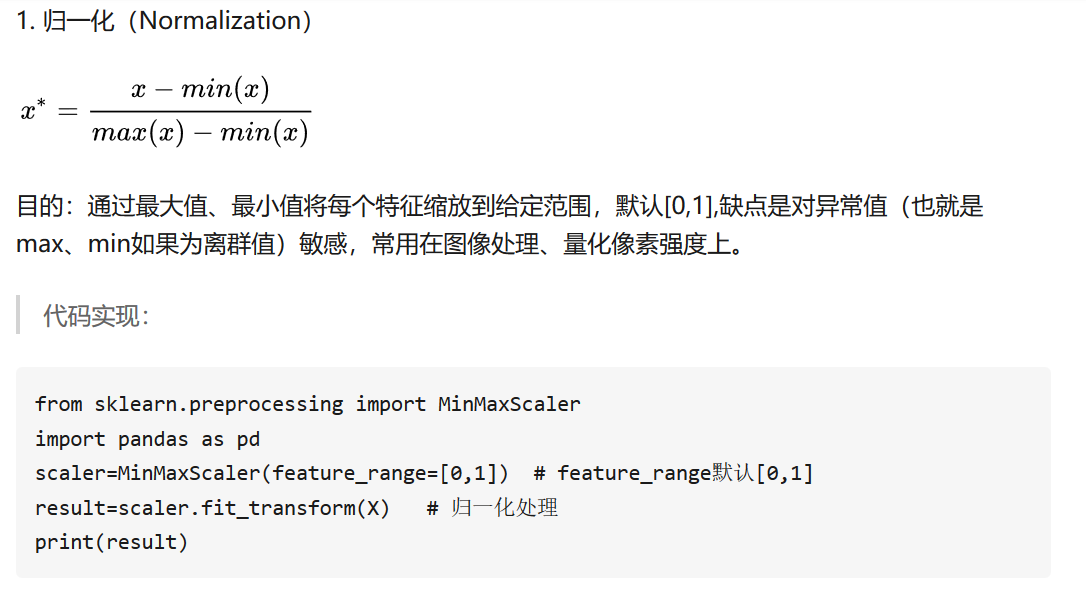

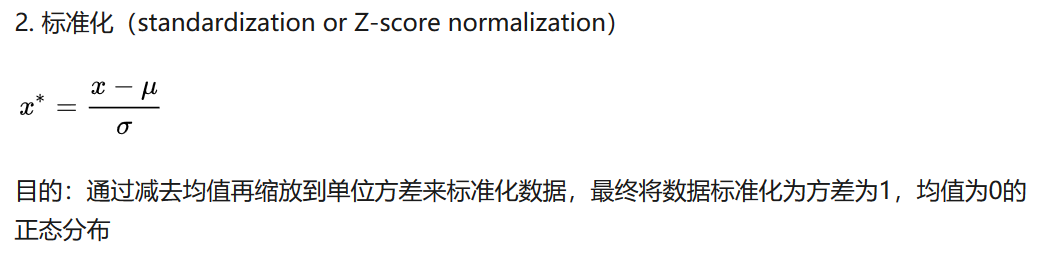

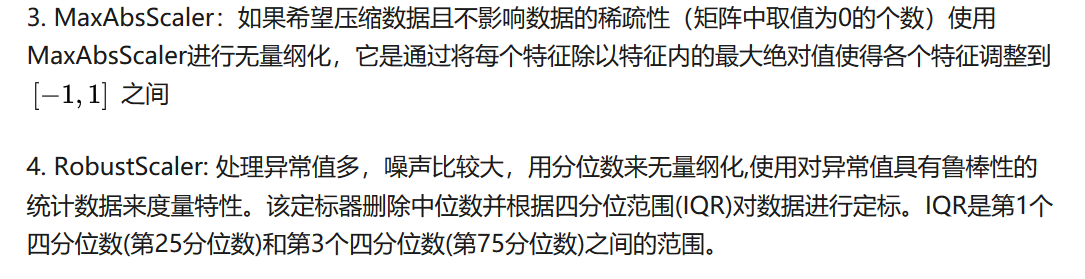

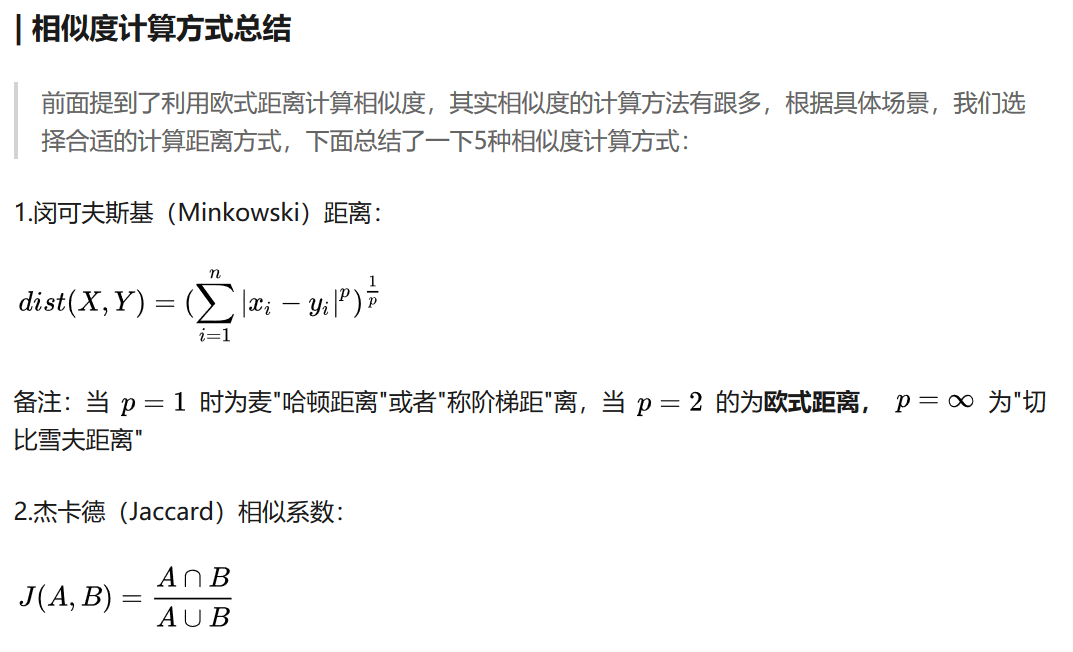

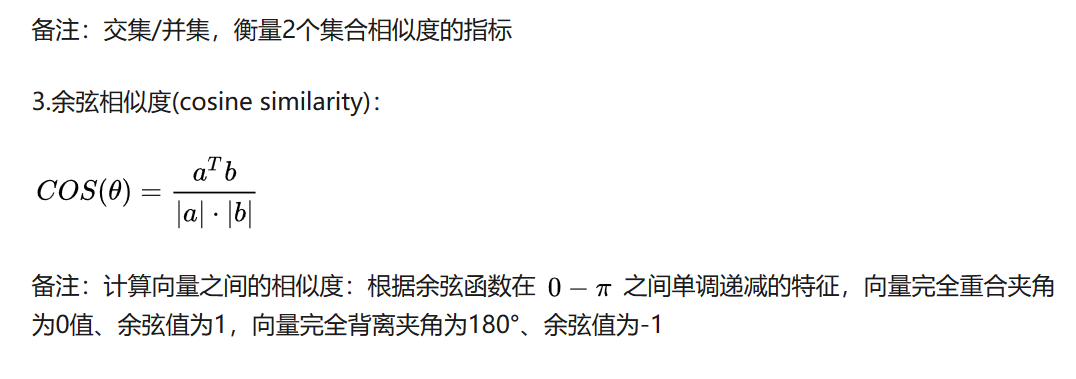

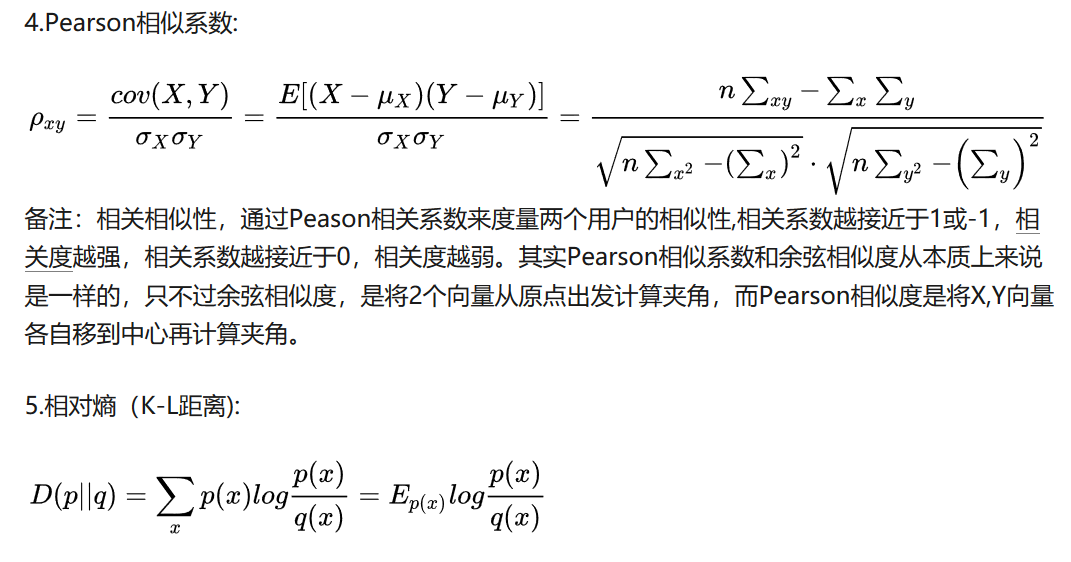

备注：相对熵又被称为Kullback-Leibler散度（Kullback-Leibler divergence）或信息散度（information divergence），是两个概率分布（probability distribution）间差异的非对称性度量。在在信息理论中，相对熵等价于两个概率分布的信息熵（Shannon entropy）的差值

In [1]:
#!/usr/bin/env python
# coding: utf-8

# 导入包
import pymysql.cursors
import pandas as pd 
from sklearn.preprocessing import RobustScaler  # 数据无量纲化的包
from sklearn.preprocessing import StandardScaler  # 数据无量纲化的包
import matplotlib.pyplot as plt  # 数据可视化包
import seaborn as sns  # Seaborn是一种基于matplotlib的图形可视化python libraty
from sklearn.preprocessing import StandardScaler # 引入数据标准化包
from sklearn.cluster import KMeans  # 从聚类包中引入KMeans聚类
from sklearn import metrics #质量评估的包

# 连接数据库
pg_conn = pymysql.connect(host='39.105.64.106',
                           port=8888,
                           user='user_name',
                           password='password',
                           db='databasename',
                           charset='utf8mb4',
                           cursorclass=pymysql.cursors.DictCursor) 

# 执行SQL
deal_sql='''
SELECT 
	A.openid
    ,COUNT(1) AS Frequency,   /*购课次数*/
	DATEDIFF(CURDATE(),MAX(created_at)) AS Rencency, /*到现在多久没有购课了*/
	ROUND(SUM(total_fee)/100,2) AS Monetary  /*累计成交金额*/
FROM live_order A
WHERE A.created_at>='2019-01-01' AND A.is_refund=0 AND A.total_fee>0 AND LENGTH(A.openid)<20
GROUP BY A.openid;
'''
deal_df=pd.read_sql(con=pg_conn,sql=deal_sql)
deal_df.openid = deal_df.openid.astype('str')


# 查看数据的分布，选择最优的数据无量纲化方法，this is Rencency distribute，大致服从正态分布
plt.figure(figsize=(10,5))
sns.distplot(deal_df.Rencency)


# 购课次数受max影响比较大，呈现长尾分布
plt.figure(figsize=(10,5))
sns.distplot(deal_df.Frequency)


# 购课金额同样受max影响比较大，呈现长尾分布
plt.figure(figsize=(10,5))
sns.distplot(deal_df.Monetary)


# RobustScaler无量纲化处理方法
X=deal_df.values[:,1:]   # 除去第一列我们选择data
X1=X[:, 0]
scaler=RobustScaler() 
result=scaler.fit_transform(X)   # 无量纲化处理
print("均值:",result.mean())
print("方差:",result.var())


# StandardScaler Z-score normalization
# function：(x-mean)/std
# purpose：将数据变成均值为0，标准差为1的分布


X=deal_df.values[:,1:]   # 除去第一列我们选择data
X1=X[:, 0]
scaler=StandardScaler() 
result1=scaler.fit_transform(X)   # 无量纲化处理
print("均值:",result1.mean())
print("方差:",result1.var())


# Calinski-Harabaz（CH）:CH指标通过计算类中各点与类中心的距离平方和来度量类内的紧密度，通过计算各类中心点与数据集中心点距离平方和来度量数据集的分离度，CH指标由分离度与紧密度的比值得到。从而，CH越大代表着类自身越紧密，类与类之间越分散，即更优的聚类结果。
# 轮廓系数silhouette（-1,1之间，值越大，聚类效果越好）
# inertia 代表簇中某一点到簇中距离的和 SSE

# 迭代，选择合适的K
ch_score = []
ss_score = []
inertia = []
for k in range(2,10):
    clf = KMeans(n_clusters=k,max_iter=1000)  # n_clusters 分类个数K ; max_iter 最大的迭代次数
    pred = clf.fit_predict(result)  # 训练数据
    ch = metrics.calinski_harabaz_score(X,pred)  #Calinski-Harabaz（CH）
    ss = metrics.silhouette_score(X,pred) # 轮廓系数
    ch_score.append(ch)
    ss_score.append(ss)
    inertia.append(clf.inertia_)  #代表簇中某一点到簇中距离的和 SSE

OperationalError: (2003, "Can't connect to MySQL server on '39.105.64.106' (timed out)")